# Features extraction using Convolutional Neural Networks (CNNs)

In this notebook, we first train a convolutional network and then use it to extract features vectors from X-Ray images. We do that by removing the classifier on top of the CNN and then run prediction of the left part of the network. When we do that, the last layer will output a tensor of shape: (training_samples, 3, 3, 256), which will be reshaped to (training_samples, 3 * 3 * 256) before feeding it to the SSO algorithm.

We use a dataset of 5,856 X-Ray images (JPEG) that belong to two categories (Pneumonia/Normal). 
The dataset is organized into 2 folders (train=5756 images, test=100 images) and contains subfolders for each image category (Pneumonia/Normal). 

It's obvious that the dataset does not have adequate training images for training CNNs, so to compensate for that we used transfer learning. We re-used the first two blocks from the VGG16 model that was pre-trained on the image net dataset, and we froze them (they became non-trainable ) then we add new trainable layers on top of that. We used only the first two blocks of the VGG16 for two main reasons. First, the information learned in the first layers of a CNN contains a general and more abstract features like colors and edges, which could be easily re-used on different datasets. Second, if we would have used more layers, that leads to a bigger and more complex model, which means a bigger number of parameters, and that could easily cause the model to overfit if we don't have enough training data. Moreover, we used data augmentation to further improve the results and prevent overfitting.


### Importing libraries

In [5]:

import cv2
import math
import numpy as np
import os
from skimage import transform
from sklearn import metrics
from keras.models import Model
from keras import models
from keras.applications.vgg16 import VGG16
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from six.moves import cPickle as pickle
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 700

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


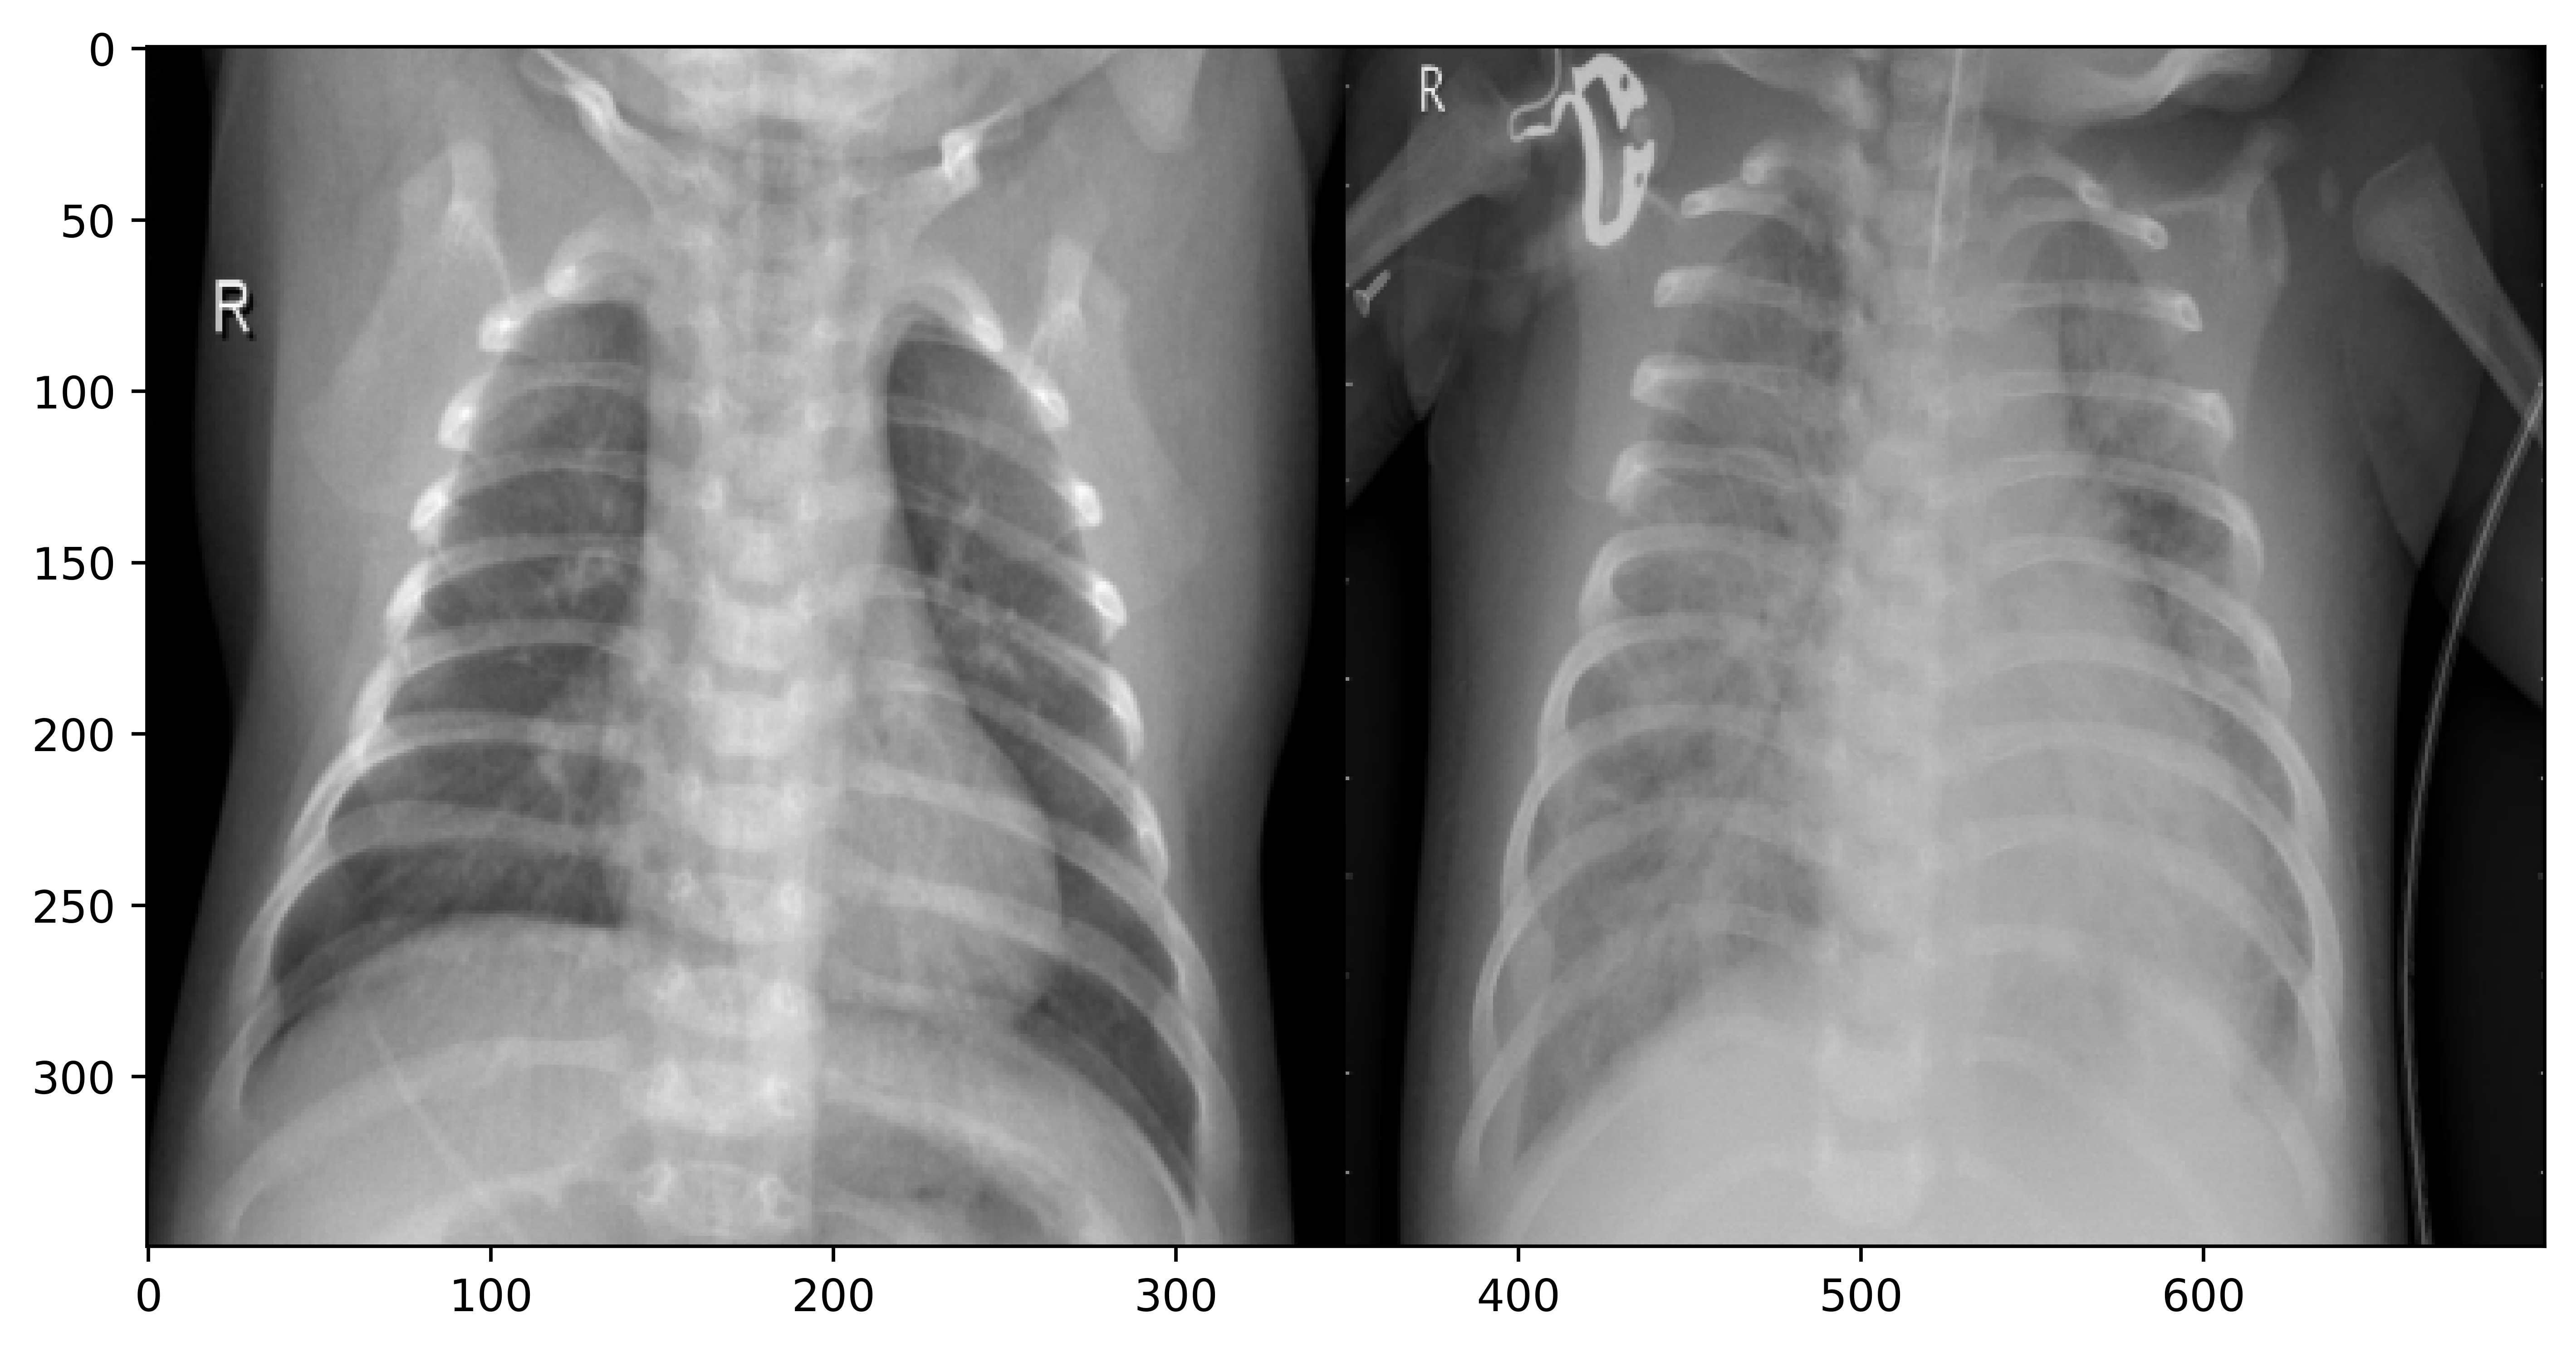

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


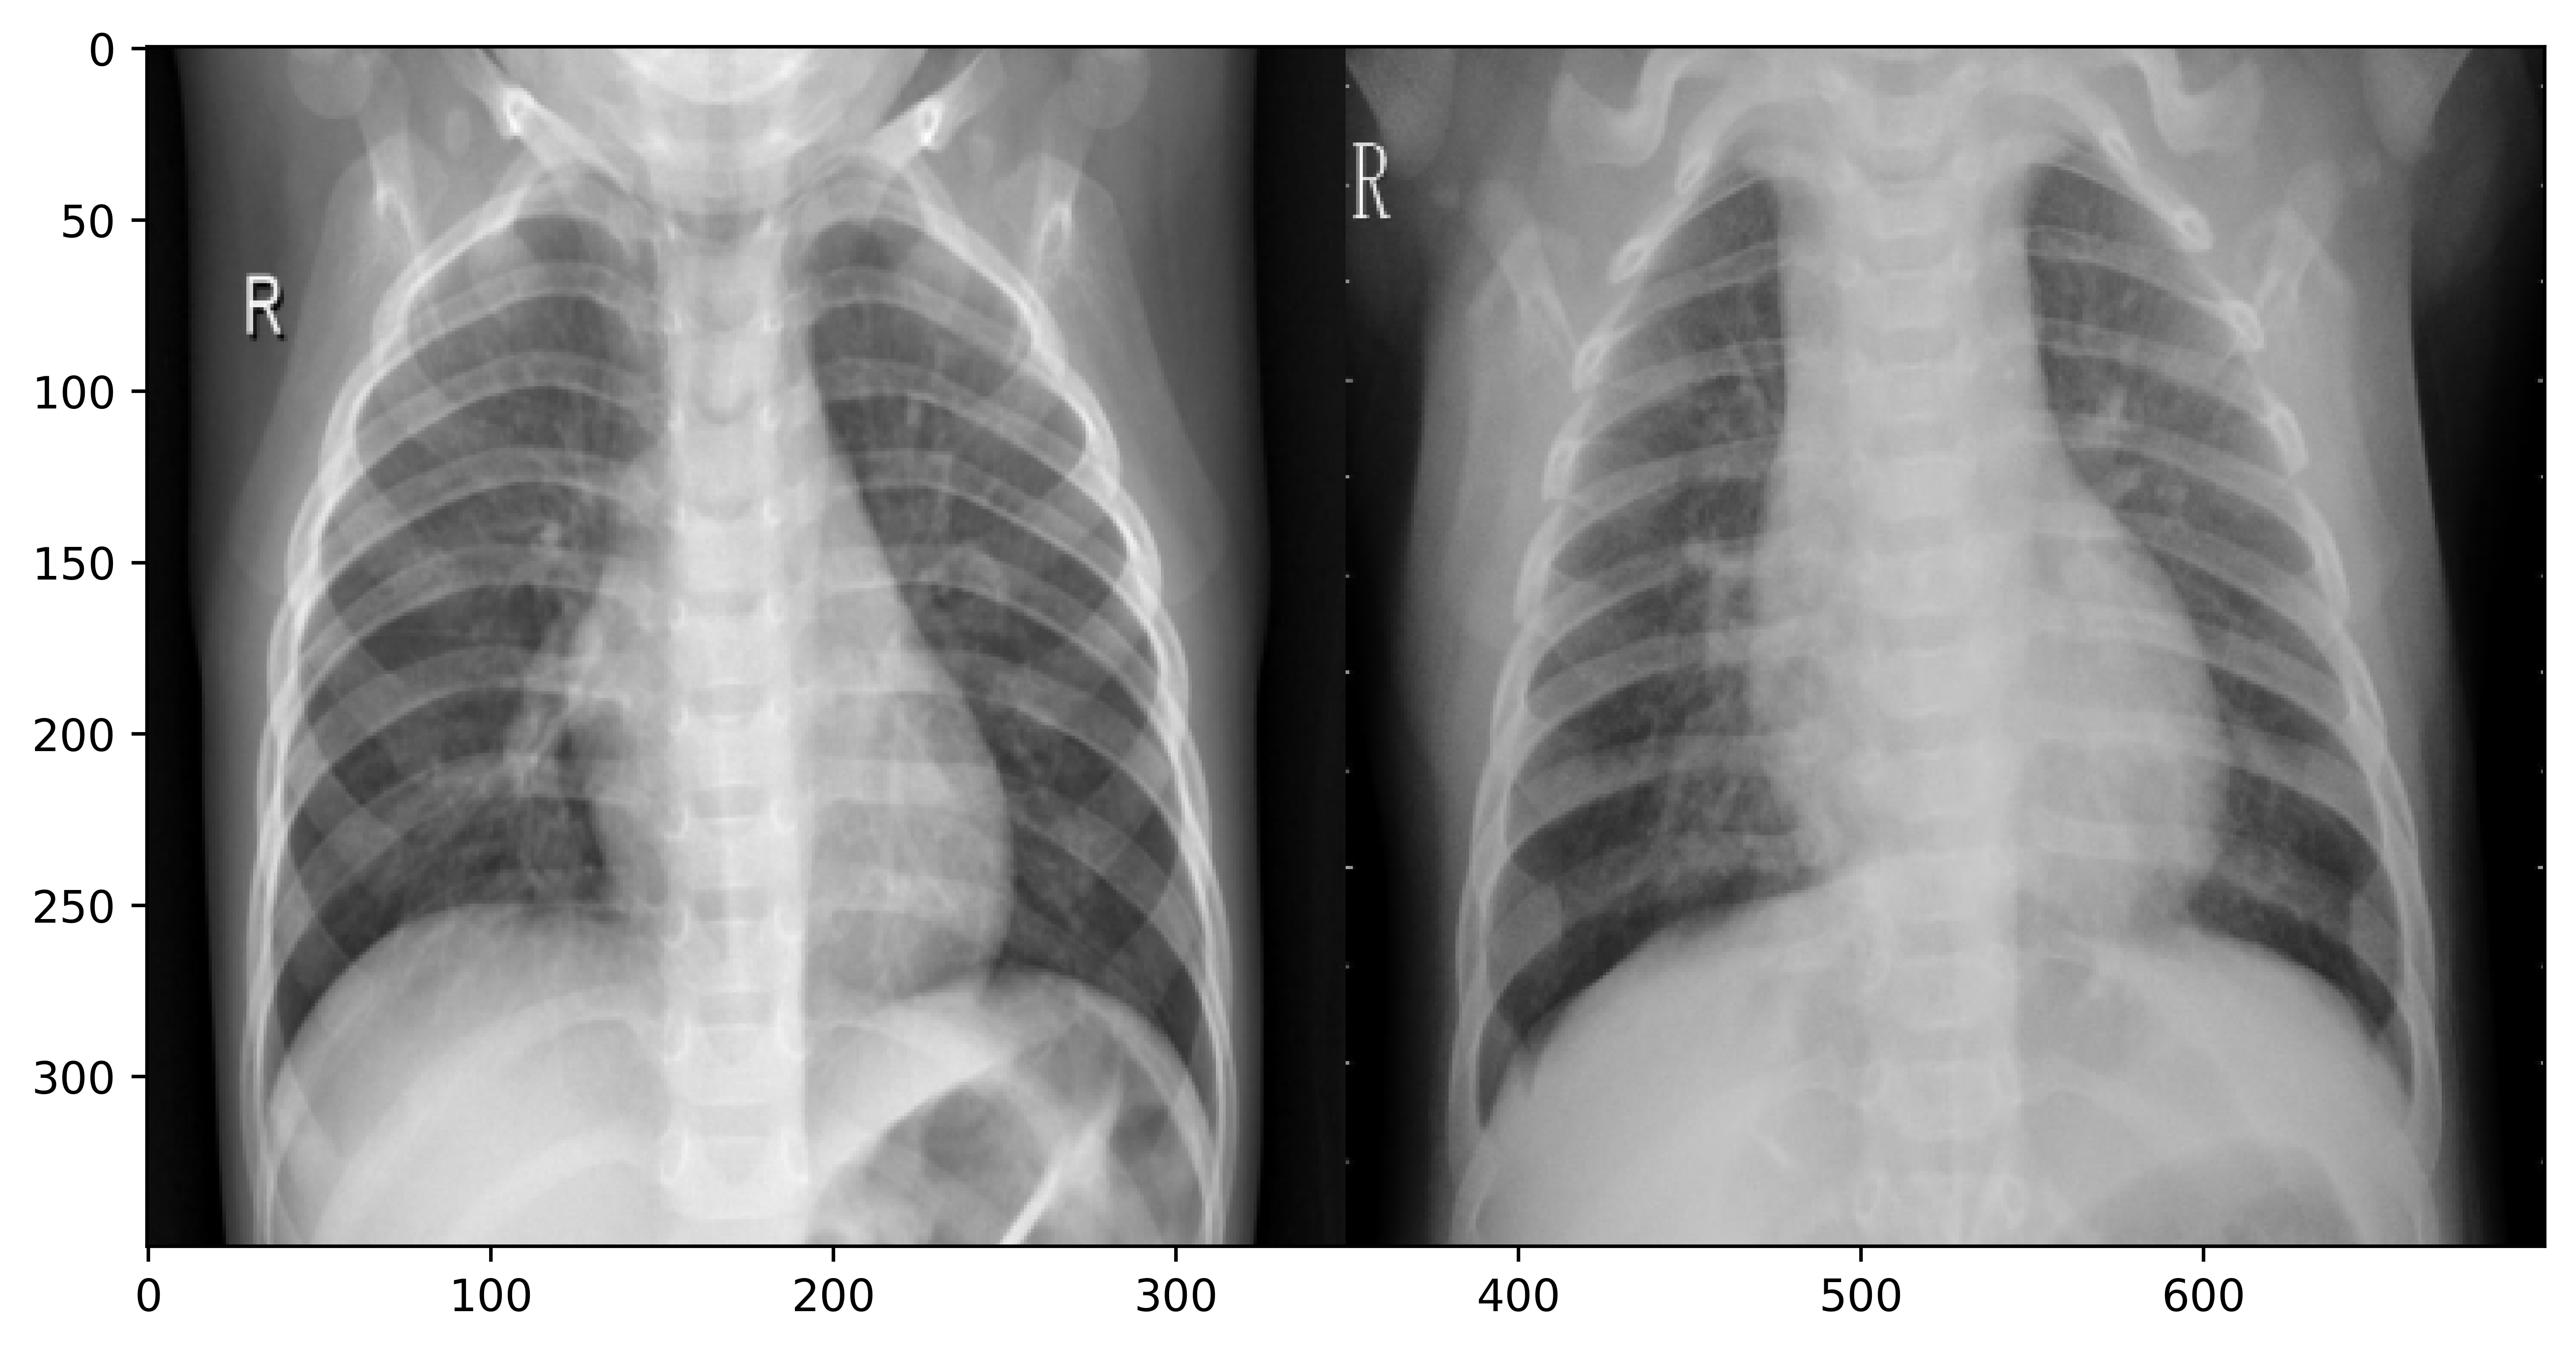

In [9]:
train_dir = "./train/"
Pimages = os.listdir(train_dir + "PNEUMONIA")
Nimages = os.listdir(train_dir + "NORMAL")

def plotter(i):
    imagep1 = cv2.imread(train_dir+"PNEUMONIA/"+Pimages[i])
    imagep1 = transform.resize(imagep1, (350, 350, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (350, 350, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,2):
    plotter(i)

### Building the model

In [1]:
img_width = 220
img_height = 220
img_channels = 3
weights='imagenet'
img_dim = (img_width, img_height, img_channels)

base_model = VGG16(
              weights=weights,
              include_top=False,
              input_shape=img_dim)

model = models.Sequential()
#base_model.trainable = False

i=0
for layer in base_model.layers:
    layer.trainable = False
    model.add(layer)
    i+=1
    if(i>6):
        break


model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 220, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 110, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 110, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 110, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 55, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)      

### Compiling the model

In [2]:
model.compile(loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['acc'])

### Image pre-processing function myFunc

In [3]:
rgb_mean = [0.4822029065559102, 0.4822029065559102, 0.4822029065559102]
def myFunc(img):
    img = np.array(img, np.float32)
    img /= 255.
    # Zero centering the data by subtracting the mean over the entire dataset
    img -= rgb_mean
    return img

### Define Keras data-augmentation generators

In [4]:
train_dir = "./train"
validation_dir = "./test"

train_datagen = ImageDataGenerator(
    rotation_range=10,
    preprocessing_function=myFunc,
    vertical_flip=False,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(preprocessing_function=myFunc)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical')

Found 5756 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Model checkpoint callback function to save the best solution during the training

In [5]:

callbacks = [ModelCheckpoint(filepath='Checkpoints/model.hdf5', monitor='val_acc',verbose=1, save_best_only=True, save_weights_only=True, mode='auto')]

### Training the model using Keras data-augmentation generators

In [6]:
history = model.fit_generator(
train_generator,
steps_per_epoch=163,
epochs=15,
callbacks=callbacks,
validation_data=validation_generator,
validation_steps=3)

Epoch 1/15
163/163 [==============================] - 165s 1s/step - loss: 0.3214 - acc: 0.8851 - val_loss: 0.3079 - val_acc: 0.8646

Epoch 00001: val_acc improved from -inf to 0.86458, saving model to Checkpoints/model.hdf5
Epoch 2/15
163/163 [==============================] - 164s 1s/step - loss: 0.1626 - acc: 0.9382 - val_loss: 0.3856 - val_acc: 0.8088

Epoch 00002: val_acc did not improve from 0.86458
Epoch 3/15
163/163 [==============================] - 165s 1s/step - loss: 0.1434 - acc: 0.9449 - val_loss: 0.4236 - val_acc: 0.7059

Epoch 00003: val_acc did not improve from 0.86458
Epoch 4/15
163/163 [==============================] - 159s 975ms/step - loss: 0.1243 - acc: 0.9520 - val_loss: 0.1294 - val_acc: 0.8971

Epoch 00004: val_acc improved from 0.86458 to 0.89706, saving model to Checkpoints/model.hdf5
Epoch 5/15
163/163 [==============================] - 171s 1s/step - loss: 0.1150 - acc: 0.9543 - val_loss: 0.3508 - val_acc: 0.8542

Epoch 00005: val_acc did not improve from 

### Displaying curves of loss and accuracy during training

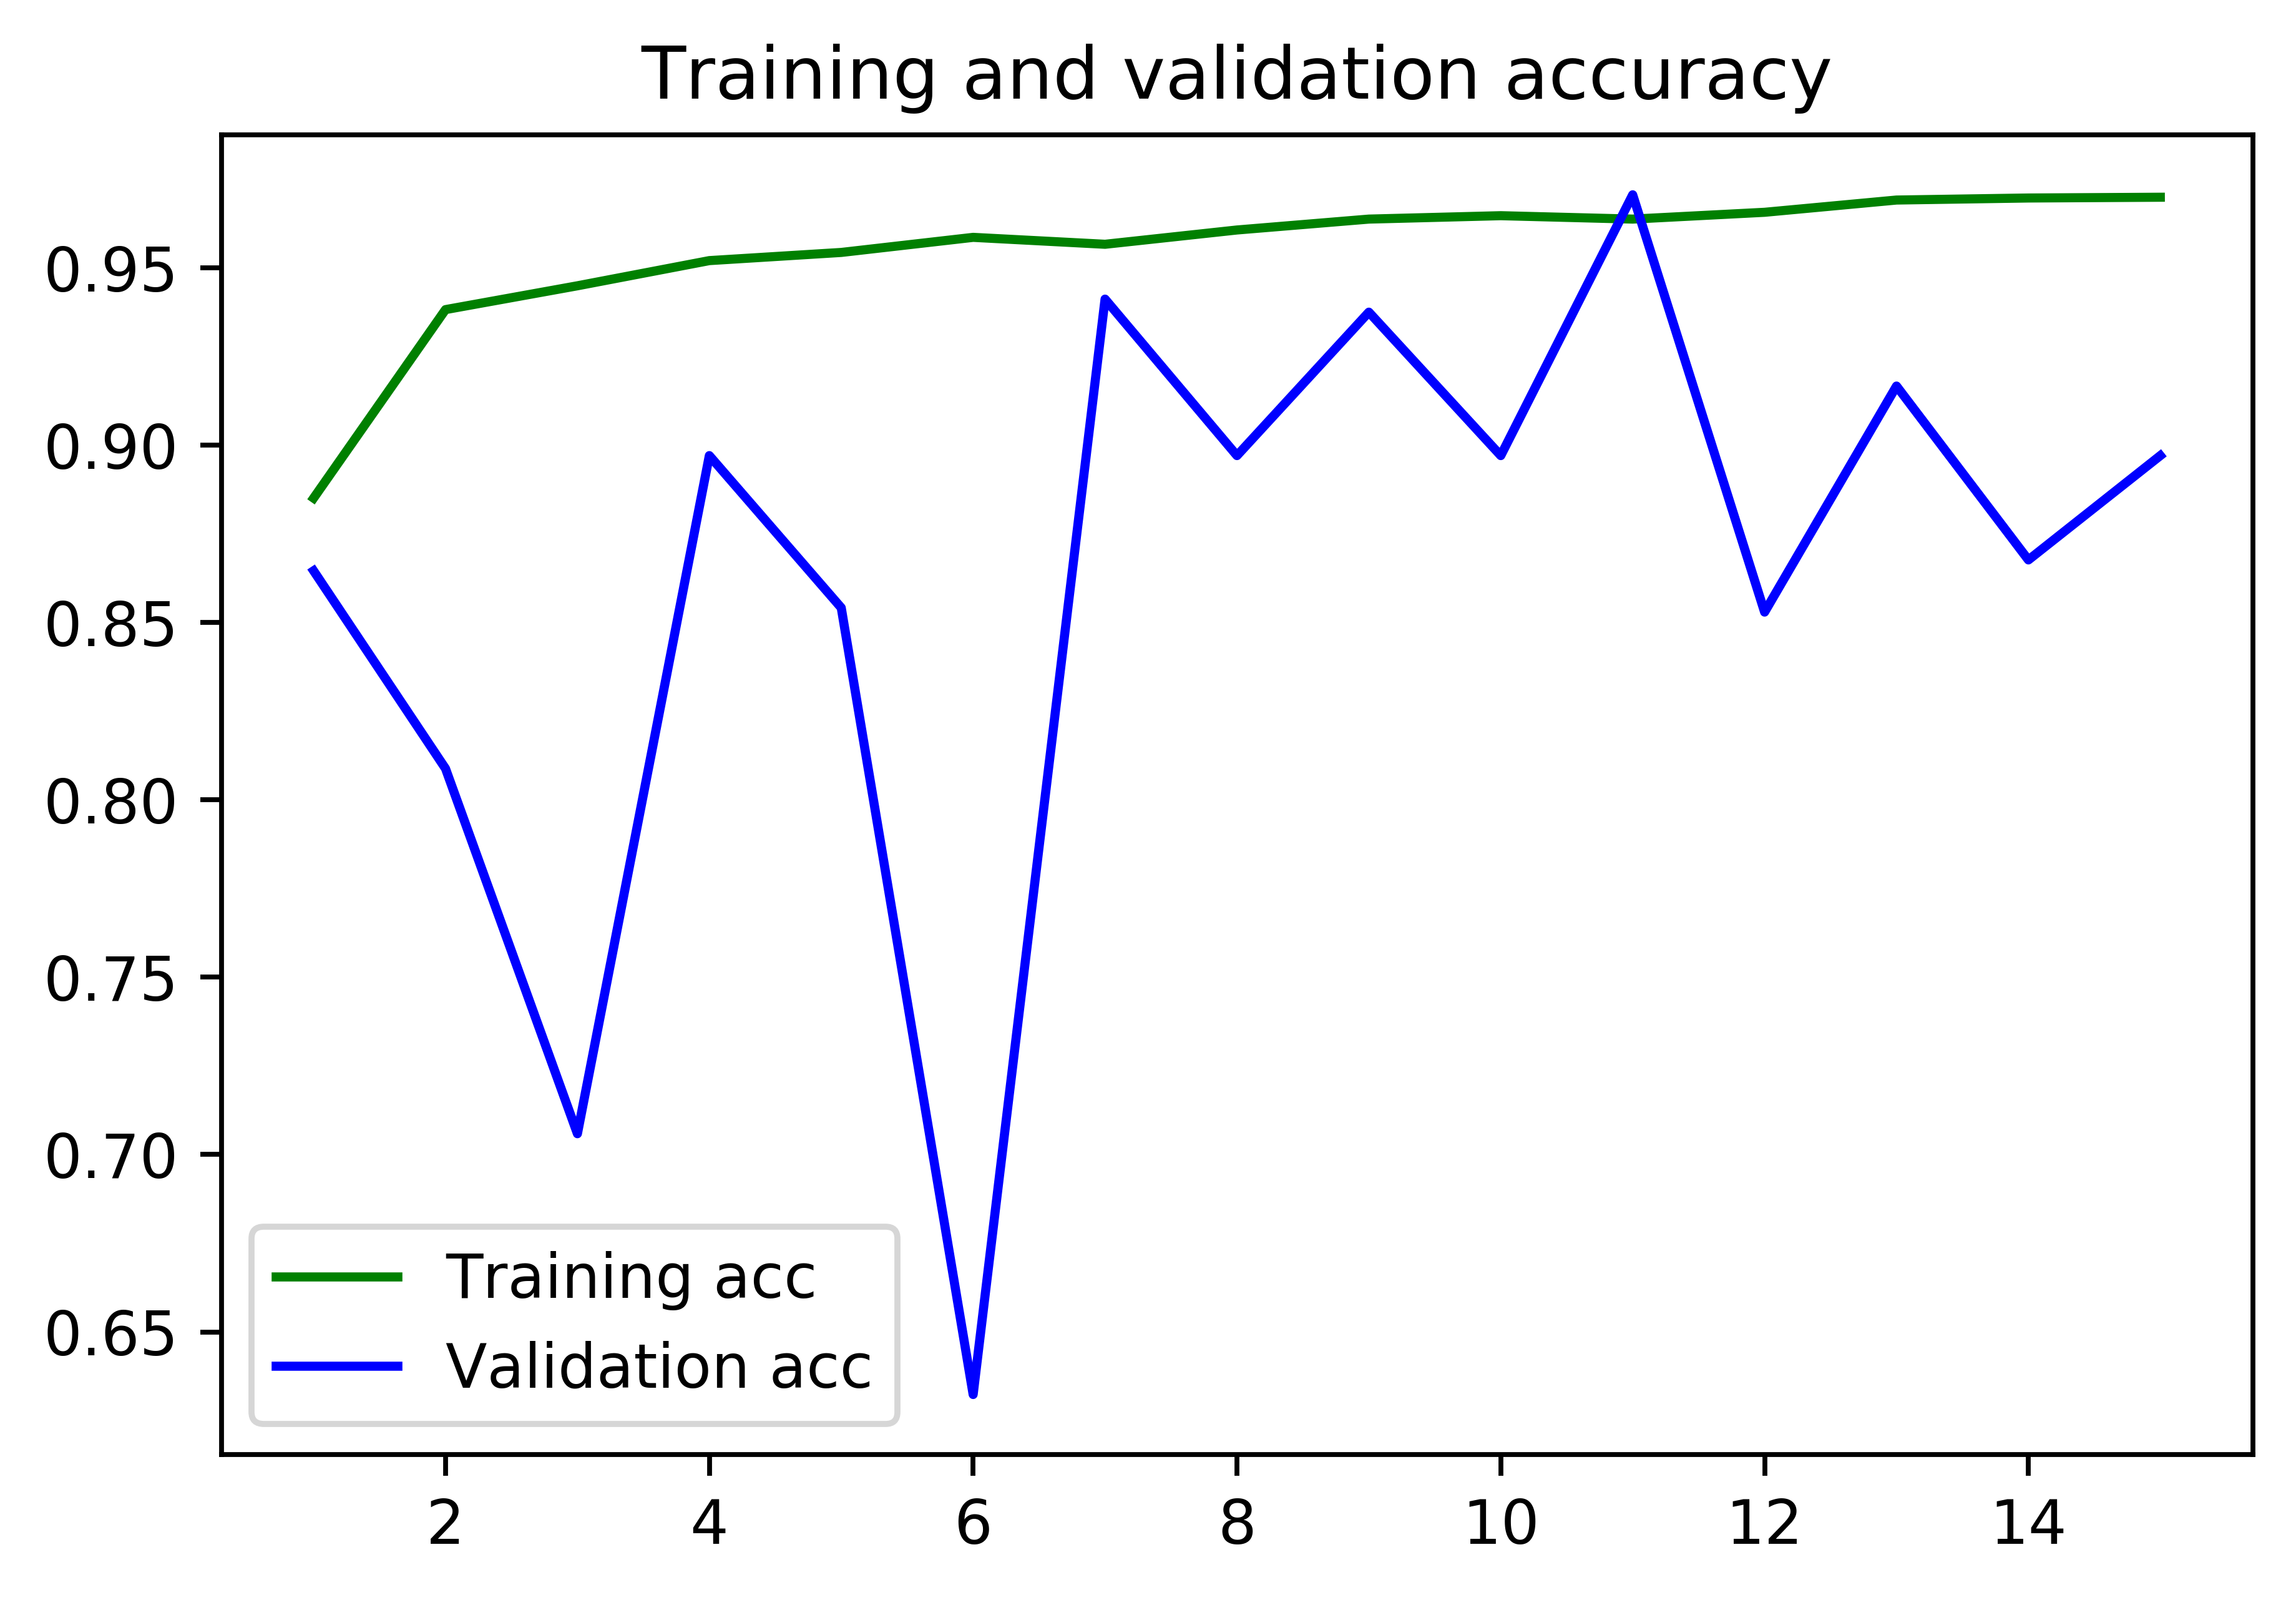

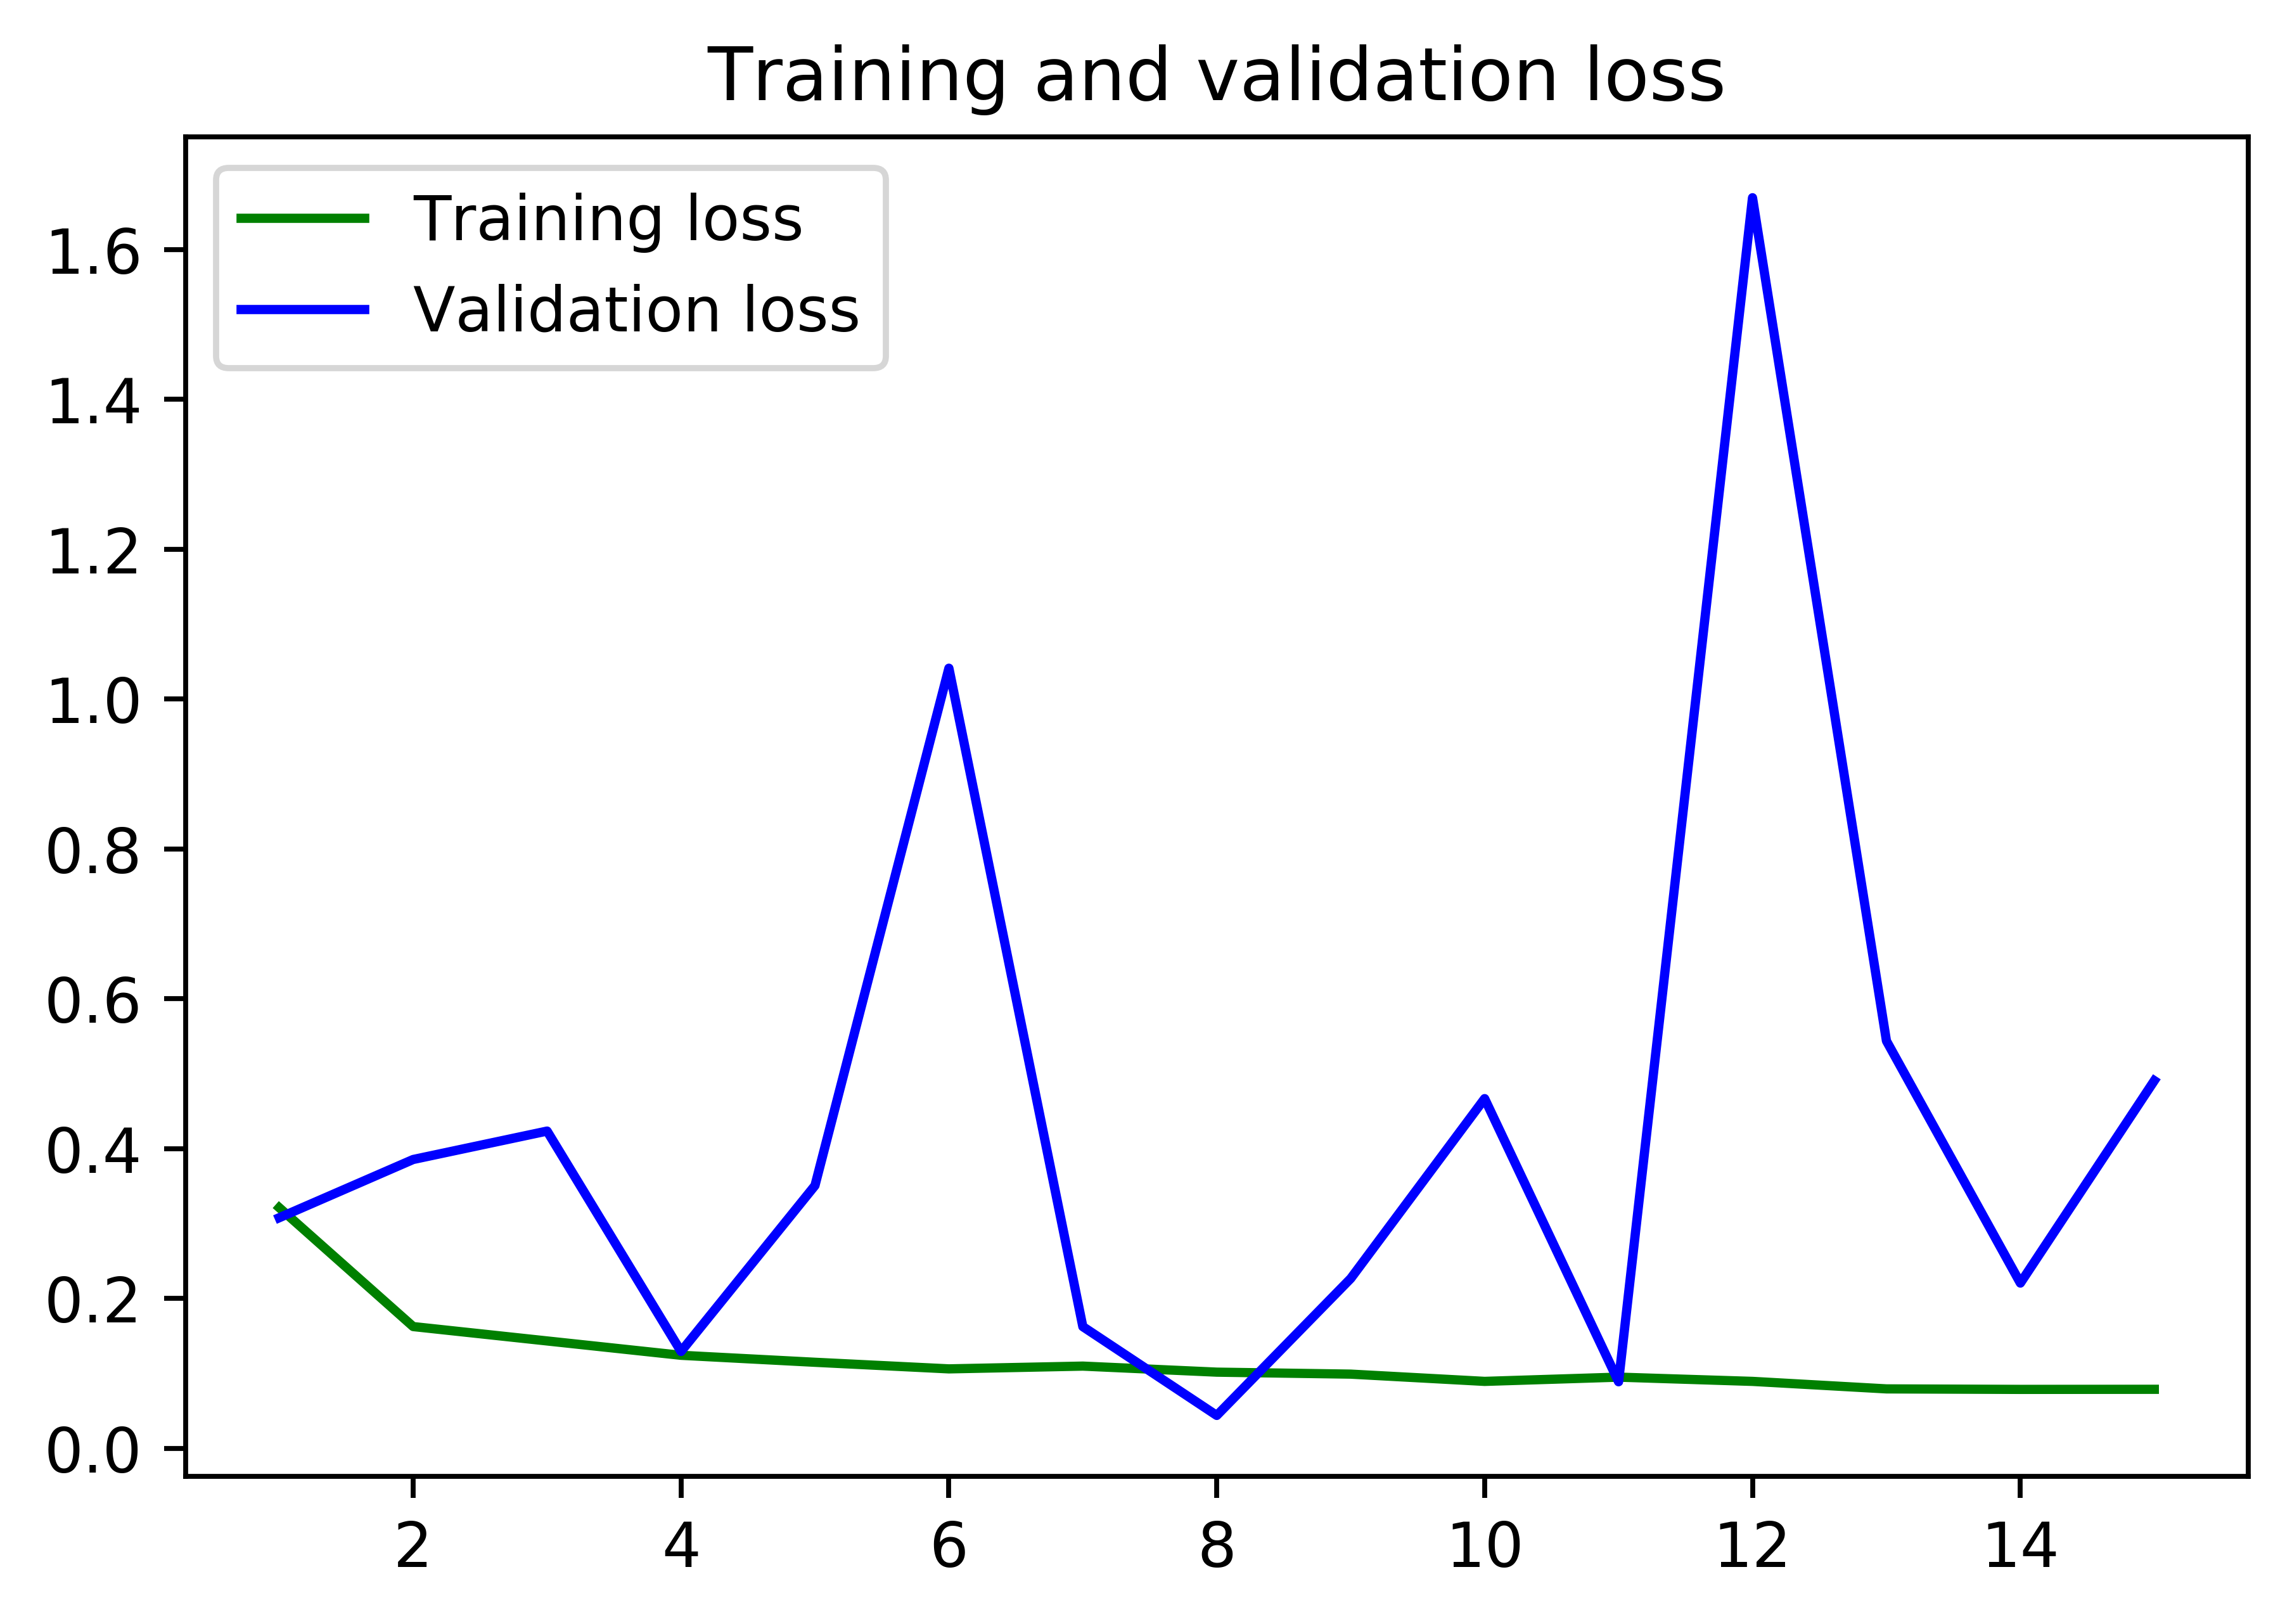

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Loading the beast solution

In [8]:
model.load_weights('Checkpoints/model.hdf5')

In [41]:
datagen = ImageDataGenerator(preprocessing_function=myFunc)
batch_size = 32

def extract_features(model, directory, sample_count, features_shape):
    features = np.zeros(shape=features_shape)
    labels = np.zeros(shape=(sample_count, 2))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(220, 220),
    batch_size=batch_size,
    class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

### Displaying confusion matrix for the training data

In [42]:
features, lables = extract_features(model = model, directory = train_dir, sample_count = 5756,
                                    features_shape = (5756, 2))



  0%|                                                                                          | 0/180 [00:00<?, ?it/s]

Found 5756 images belonging to 2 classes.




  1%|▍                                                                                 | 1/180 [00:01<05:04,  1.70s/it]

  1%|▉                                                                                 | 2/180 [00:03<04:41,  1.58s/it]

  2%|█▎                                                                                | 3/180 [00:04<04:20,  1.47s/it]

  2%|█▊                                                                                | 4/180 [00:05<04:05,  1.40s/it]

  3%|██▎                                                                               | 5/180 [00:06<04:02,  1.38s/it]

  3%|██▋                                                                               | 6/180 [00:08<03:55,  1.36s/it]

  4%|███▏                                                                              | 7/180 [00:09<03:48,  1.32s/it]

  4%|███▋                                                                              | 8/180 [00:10<03:48,  1.33s/it]

  5%|████                     

 72%|█████████████████████████████████████████████████████████▎                      | 129/180 [02:44<01:05,  1.28s/it]

 72%|█████████████████████████████████████████████████████████▊                      | 130/180 [02:46<01:04,  1.28s/it]

 73%|██████████████████████████████████████████████████████████▏                     | 131/180 [02:47<01:02,  1.28s/it]

 73%|██████████████████████████████████████████████████████████▋                     | 132/180 [02:49<01:08,  1.42s/it]

 74%|███████████████████████████████████████████████████████████                     | 133/180 [02:50<01:08,  1.47s/it]

 74%|███████████████████████████████████████████████████████████▌                    | 134/180 [02:52<01:11,  1.56s/it]

 75%|████████████████████████████████████████████████████████████                    | 135/180 [02:53<01:07,  1.51s/it]

 76%|████████████████████████████████████████████████████████████▍                   | 136/180 [02:55<01:04,  1.46s/it]

 76%|███████████████████████████

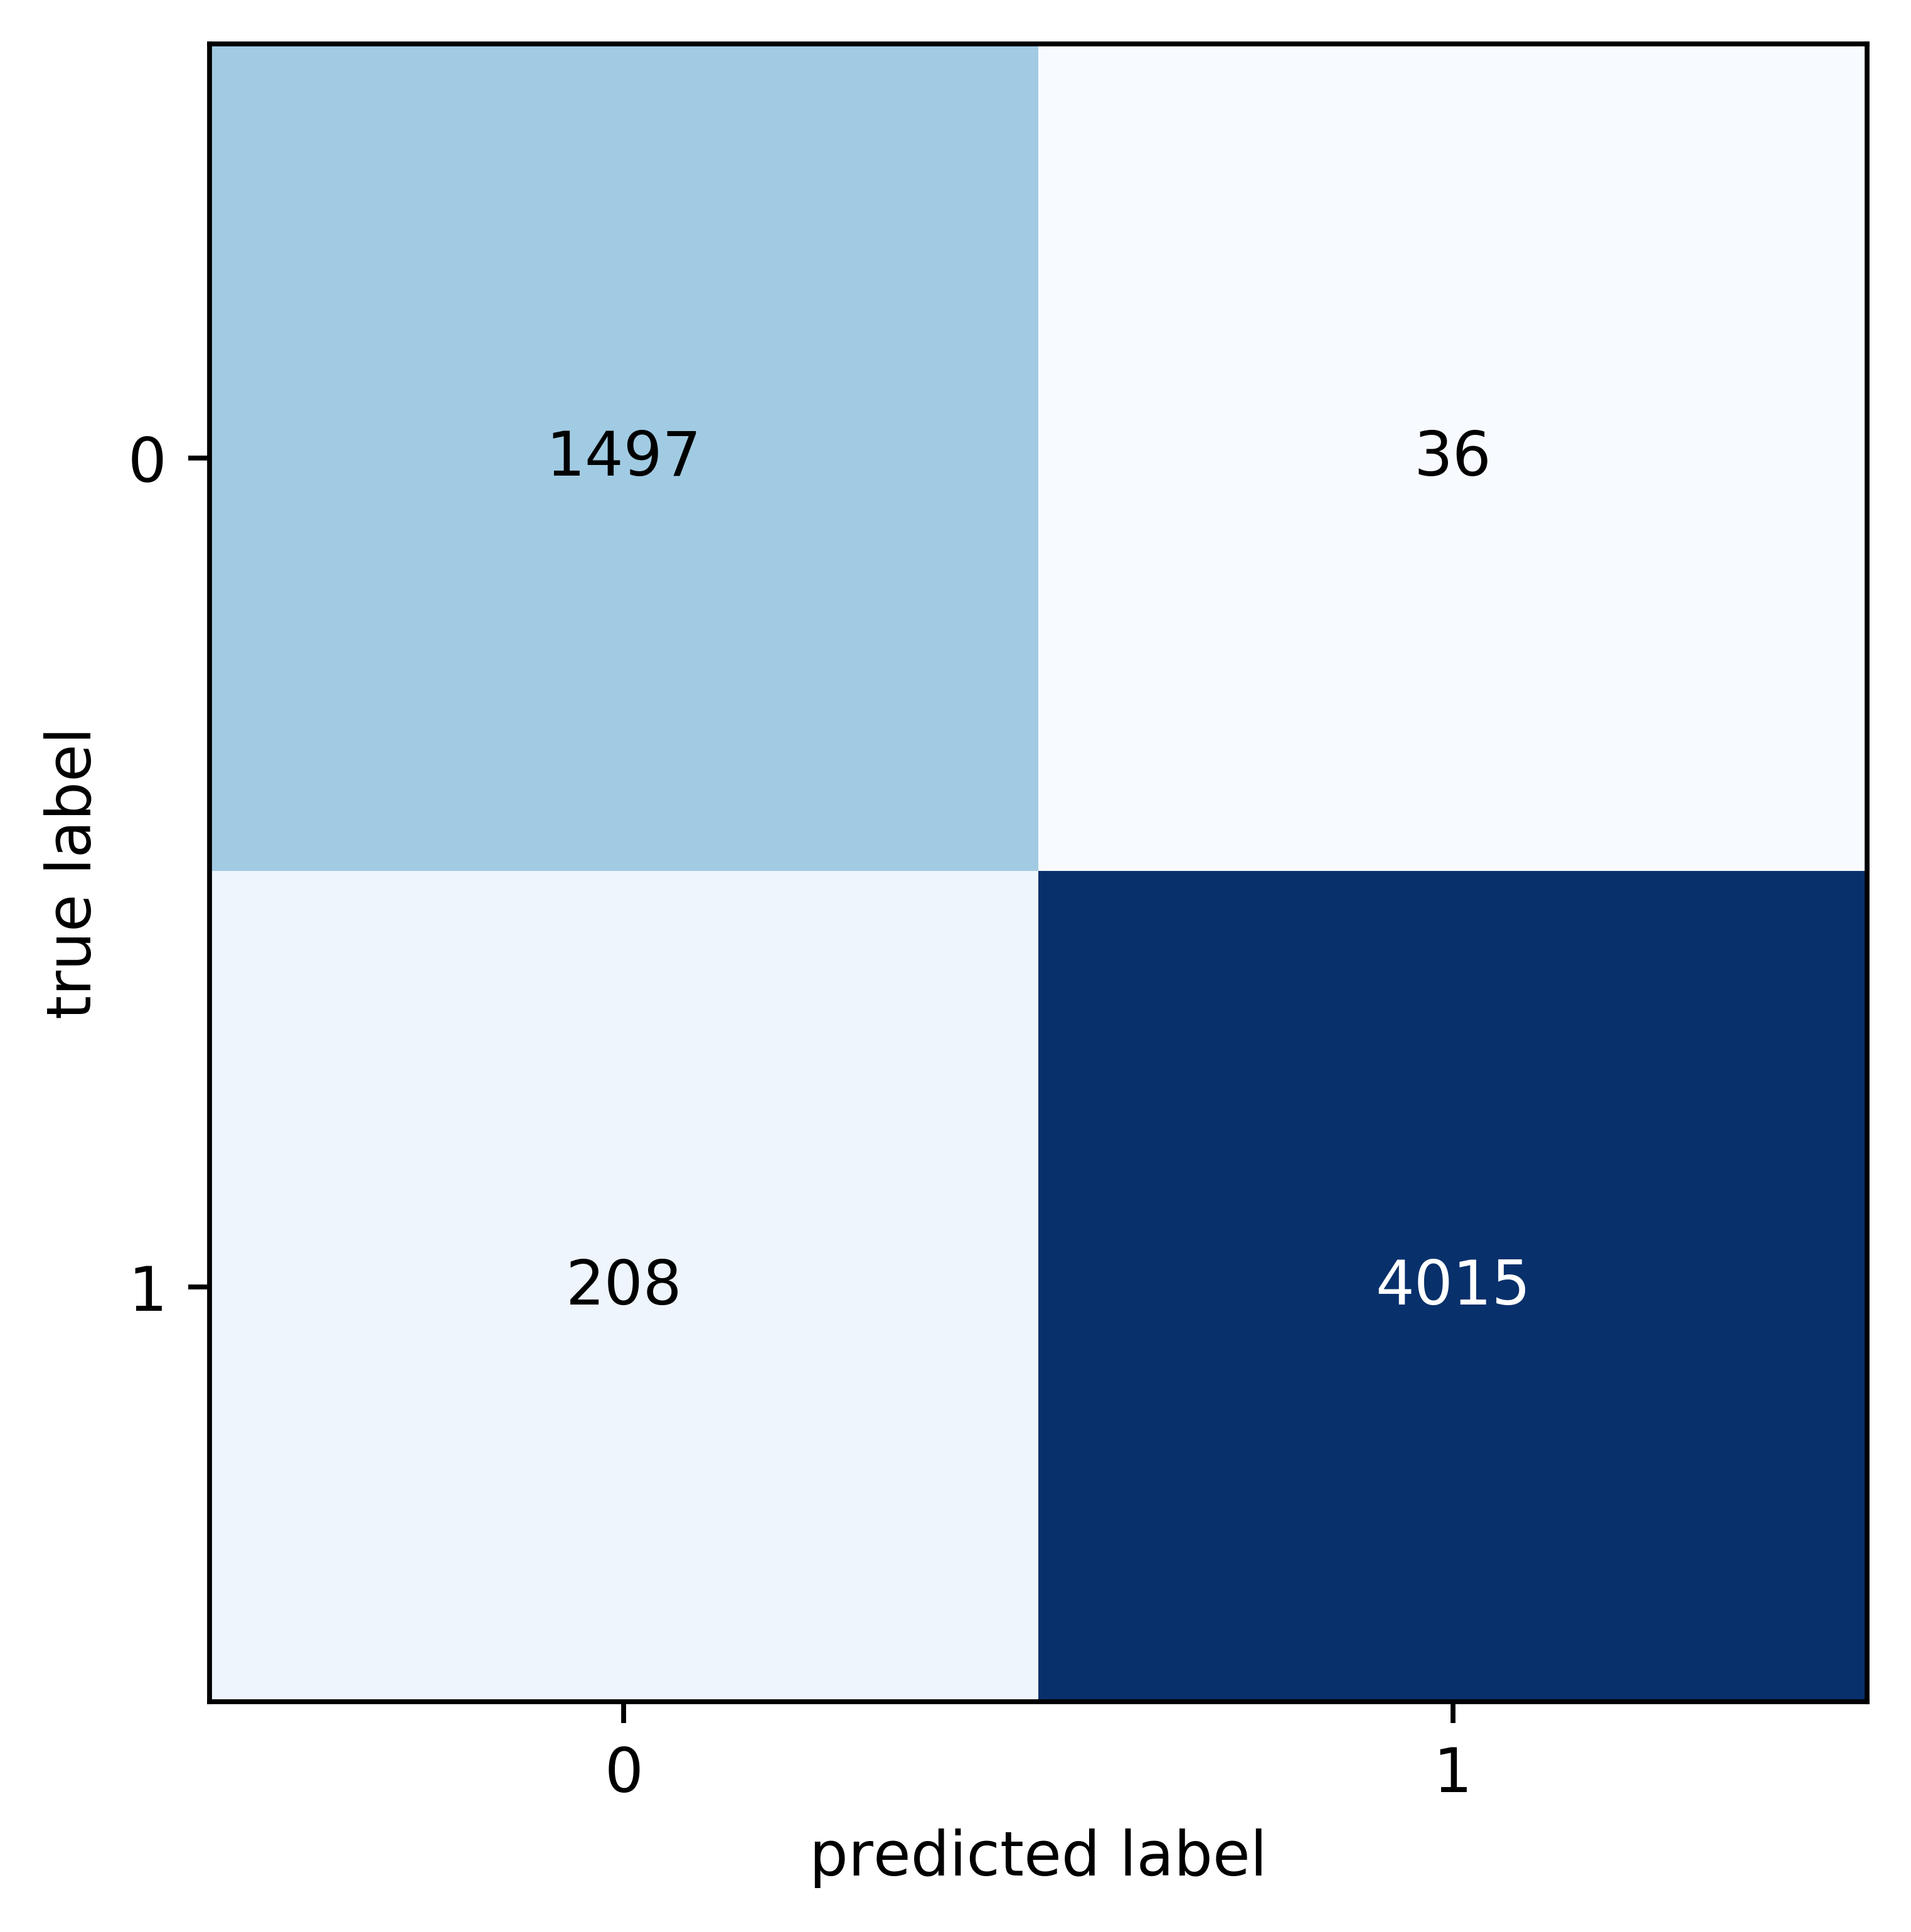

In [43]:
pred = np.argmax(features,axis = 1) 
y_true = np.argmax(lables,axis = 1)

CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### precision = True Positive / (True Positive + False Positive)
### recall = True Positive / (True Positive + False Negative)

In [1]:
#Recall
4015/(4015+208)

0.9507459152261426

In [2]:
#Precision
4015/(4015+36)

0.9911133053567021

## Extract features to use them for training the SSO

In [9]:

x = (model.layers[-3].output)


model2 = Model(input=model.input, output=x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 220, 220, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 220, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 110, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 110, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 110, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 55, 128)       0   

c:\users\belal\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """


In [24]:
features, lables = extract_features(model = model2, directory = train_dir, sample_count = 5756,
                                    features_shape = (5756, 3, 3, 256))


  0%|                                                                                          | 0/180 [00:00<?, ?it/s]

Found 5756 images belonging to 2 classes.



 73%|██████████████████████████████████████████████████████████▋                     | 132/180 [03:06<01:09,  1.45s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 179/180 [04:16<00:01,  1.41s/it]

In [12]:
features.shape

(5756, 3, 3, 256)

### Save extracted training featues  as pickle file

In [13]:

try:
    f = open("x_ray_train.pickle", 'wb')
    save = {
      'features': features,
      'labels': lables,
      }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)

## Extract features to use them for testing the SSO

In [14]:
features, lables = extract_features(model = model2, directory = validation_dir, sample_count = 100,
                                    features_shape = (100, 3, 3, 256))


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Found 100 images belonging to 2 classes.



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:04<00:01,  1.62s/it]


### Save extracted testing featues as pickle file

In [15]:
try:
    f = open("x_ray_val.pickle", 'wb')
    save = {
      'features': features,
      'labels': lables,
      }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)

### Displaying confusion matrix for the validation data

In [16]:
features, lables = extract_features(model = model, directory = validation_dir, sample_count = 100,
                                    features_shape = (100, 2))


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Found 100 images belonging to 2 classes.



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:02,  2.07s/it]


In [17]:
features[99]

array([0.01334985, 0.98665011])

In [18]:
pred = np.argmax(features,axis = 1) 
y_true = np.argmax(labels,axis = 1)

In [19]:
pred

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [20]:
y_true

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

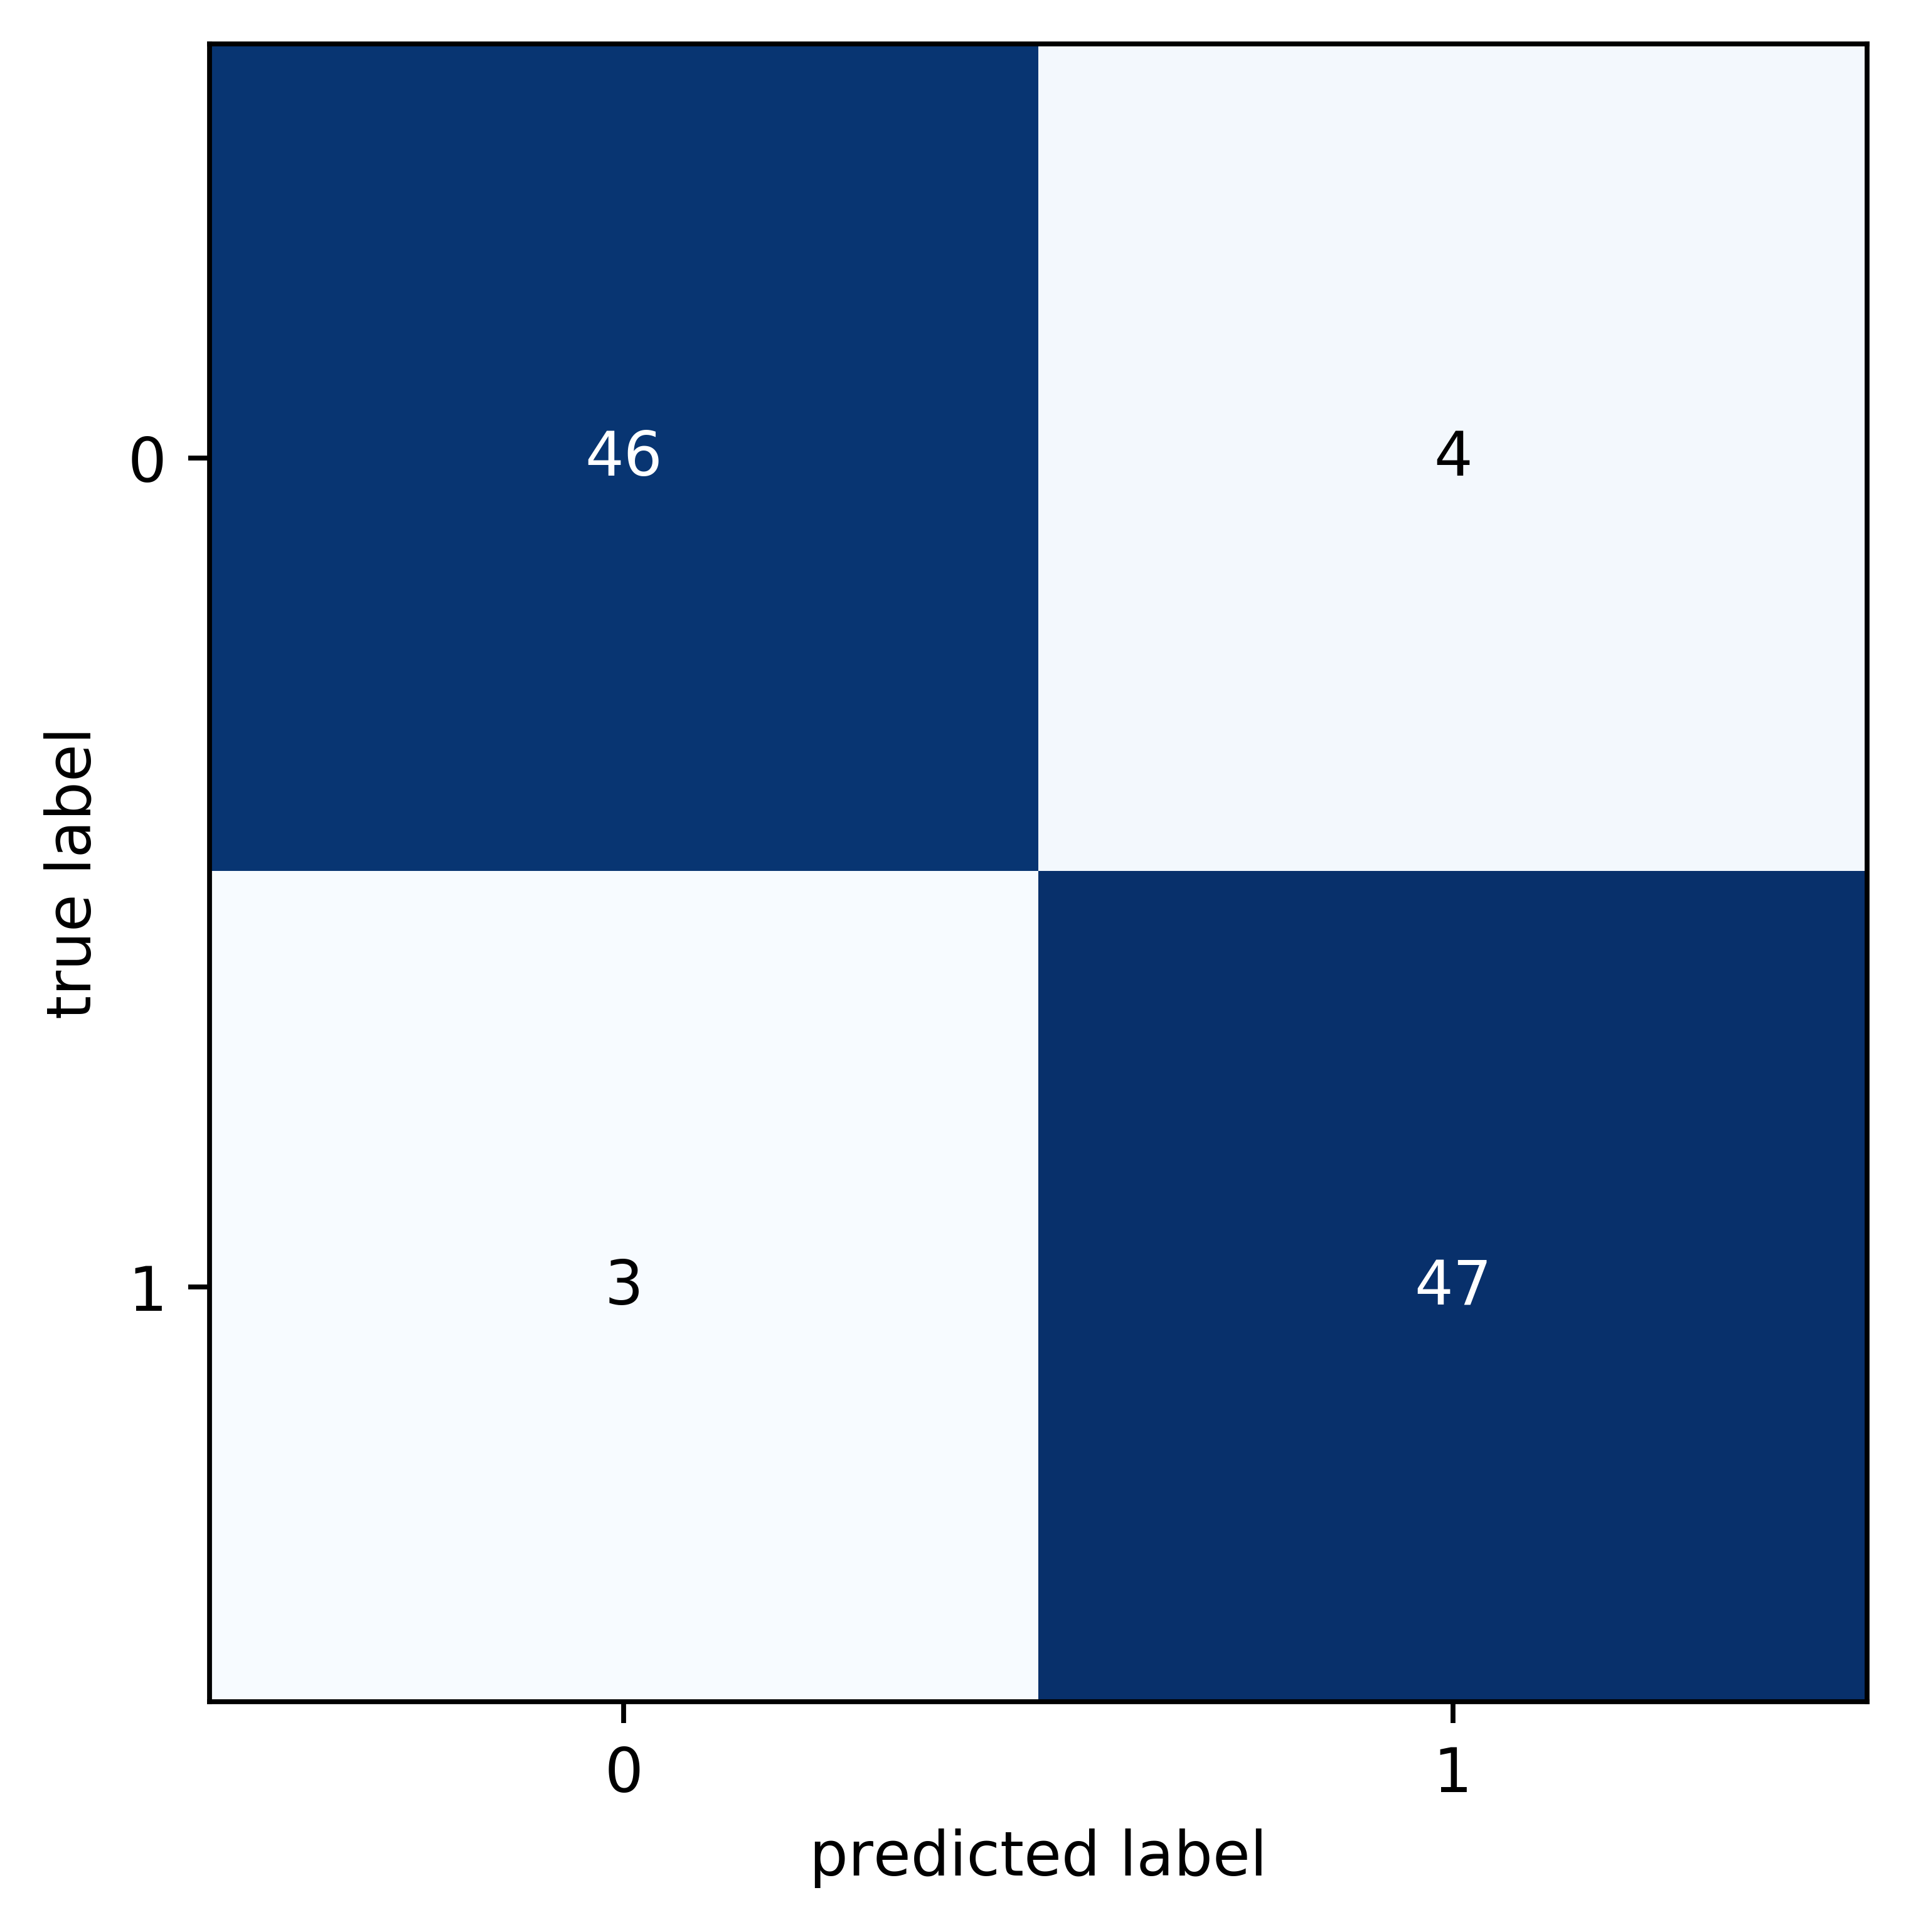

In [21]:
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [3]:
#Recall
47/(47+3)

0.94

In [4]:
#Precision
47/(47+4)

0.9215686274509803